## Introduction
The goal of this notebook is show how to train a PCA model on AWS Sagemaker. The training data resides on S3 in `s3://skuchkula-sagemaker-airbnb/` location. Objective is to apply Principal Components Analysis (PCA) on airbnb locations located in NYC. 

### STEP 1: Create an S3 bucket which contains sagemaker name in it.
Having the sagemaker name is not a requirement. However, as per Amazon documentation:

> Note: 
Amazon SageMaker needs permission to access these buckets. You grant permission with an IAM role, which you create in the next step when you create an Amazon SageMaker notebook instance. This IAM role automatically gets permissions to access any bucket that has sagemaker in the name. It gets these permissions through the AmazonSageMakerFullAccess policy, which Amazon SageMaker attaches to the role. If you add a policy to the role that grants the SageMaker service principal S3FullAccess permission, the name of the bucket does not need to contain sagemaker.

### STEP 2: Create an Amazon SageMaker Notebook instance
An Amazon SageMaker notebook instance is a fully managed machine learning (ML) Amazon Elastic Compute Cloud (Amazon EC2) compute instance that runs the Jupyter Notebook App. You use the notebook instance to create and manage Jupyter notebooks that you can use to prepare and process data and to train and deploy machine learning models. 

To create an Amazon SageMaker notebook instance

- Open the Amazon SageMaker console at https://console.aws.amazon.com/sagemaker/.

- Choose Notebook instances, then choose Create notebook instance.

- On the Create notebook instance page, provide the following information (if a field is not mentioned, leave the default values):

- For Notebook instance name, type a name for your notebook instance.

- For Instance type, choose ml.t2.medium. This is the least expensive instance type that notebook instances support, and it suffices for this exercise.

- For IAM role, choose Create a new role, then choose Create role.

- Choose Create notebook instance.

In a few minutes, Amazon SageMaker launches an ML compute instance—in this case, a notebook instance—and attaches an ML storage volume to it. The notebook instance has a preconfigured Jupyter notebook server and a set of Anaconda libraries.

### Step 3: Create notebook instance and start writing code

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# sagemaker libraries
import boto3
import sagemaker

### Step 4:  Get data from S3

In [2]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='skuchkula-sagemaker-airbnb'

In [3]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['detailed_listings.csv', 'summary_listings.csv']


In [4]:
# there is one file --> one key
detailed_listings=files[0]

In [5]:
def get_data_frame(bucket_name, file_name):
    # get an S3 object by passing in the bucket and file name
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    
    # information is in the "Body" of the object
    data_body = data_object["Body"].read()
    
    # read in bytes data
    data_stream = io.BytesIO(data_body)
    
    # create a dataframe
    df = pd.read_csv(data_stream, header=0, delimiter=",", low_memory=False)
    
    return df

In [6]:
df_detailed_listings = get_data_frame(bucket_name, detailed_listings)

In [7]:
df_detailed_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20190806030549,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,https://www.airbnb.com/rooms/3647,20190806030549,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,https://www.airbnb.com/rooms/3831,20190806030549,2019-08-06,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,https://www.airbnb.com/rooms/5022,20190806030549,2019-08-06,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,https://www.airbnb.com/rooms/5099,20190806030549,2019-08-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment is true New York ...,none,My neighborhood in Midtown East is called Murr...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


The Detailed listings contains about 106 different features for each of the Airbnb locations. We need to do some EDA to check if we can trim down some features.

In [8]:
print("Detailed Listings row, cols: ", df_detailed_listings.shape)

Detailed Listings row, cols:  (48864, 106)


In [9]:
# check how the data types are distributed.
# pandas does its best to interpret the datatype while reading in
# however it is our duty to check if the datatype makes sense
df_detailed_listings.dtypes.value_counts()

object     63
float64    22
int64      21
dtype: int64

### Step 5: Data Cleaning
The focus of this notebook on cleaning the data and storing the cleaned version back into S3. 

In [10]:
# Set the display properties so that we can inspect the data
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

When working with a dataset which contains many different types of columns, it is best to break them down by type and inspect the cleanliness of each type. We will start with Object types.

#### Object types
Using `select_dtypes` we can filter out the desired type of columns.

In [11]:
df_detailed_listings.select_dtypes(include=['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',


By inspecting some values of object types, it becomes evident that some columns are just not that useful for our analysis. Example, the urls, last_scraped etc. Shown below are a list of columns that we can safely drop without much loss of information needed for our analysis.

In [12]:
df_detailed_listings.select_dtypes(include=['object']).head()

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,last_review,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,https://www.airbnb.com/rooms/2595,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",https://a0.muscache.com/im/pictures/f0813a11-4...,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,90%,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",Midtown,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,f,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,"$1,995.00",NaN,$350.00,$100.00,$0.00,a week ago,t,2019-08-07,2009-11-21,2019-07-14,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t
1,https://www.airbnb.com/rooms/3647,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,https://a0.muscache.com/im/pictures/838341/9b3...,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,within a day,100%,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,t,Apartment,Private room,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,NaN,NaN,$200.00,$75.00,$20.00,35 months ago,t,2019-08-06,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t
2,https://www.airbnb.com/rooms/3831,2019-08-06,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,https://a0.muscache.com/im/pictures/e49999c2-9...,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,90%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill

In [13]:
drop_object_cols = ['listing_url',
             'last_scraped',
             'experiences_offered',
             'picture_url',
             'host_url',
             'host_name',
             'host_since',
             'host_location',
             'host_about',
             'host_thumbnail_url',
             'host_picture_url',
             'host_neighbourhood',
             'street',
             'neighbourhood',
             'city',
             'state',
             'zipcode',
             'market',
             'smart_location',
             'country_code',
             'country',
             'calendar_updated',
             'calendar_last_scraped',
             'first_review',
             'last_review' 
            ]

#### float64 type

In [14]:
df_detailed_listings.select_dtypes(include=['float64']).columns

Index(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [15]:
df_detailed_listings.select_dtypes(include=['float64']).head()

,thumbnail_url,medium_url,xl_picture_url,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,square_feet,minimum_nights_avg_ntm,maximum_nights_avg_ntm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,NaN,NaN,NaN,NaN,5.0,5.0,40.75362,-73.98377,1.0,0.0,1.0,NaN,1.0,1125.0,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0.39
1,NaN,NaN,NaN,NaN,1.0,1.0,40.80902,-73.94190,1.0,1.0,1.0,NaN,3.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,40.68514,-73.95976,1.0,1.0,4.0,500.0,1.0,730.0,90.0,10.0,9.0,10.0,9.0,10.0,9.0,4.64
3,NaN,NaN,NaN,NaN,1.0,1.0,40.79851,-73.94399,1.0,NaN,1.0,NaN,10.0,120.0,93.0,10.0,9.0,10.0,10.0,9.0,10.0,0.10
4,NaN,NaN,NaN,NaN,1.0,1.0,40.74767,-73.97500,1.0,1.0,1.0,NaN,3.0,21.0,89.0,10.0,9.0,10.0,10.0,9.0,9.0,0.60


In [16]:
drop_float_cols = ['thumbnail_url',
                   'medium_url',
                   'xl_picture_url'
                  ]

#### int64 type

In [17]:
df_detailed_listings.select_dtypes(include=['int64']).columns

Index(['id', 'scrape_id', 'host_id', 'accommodates', 'guests_included',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [18]:
df_detailed_listings.select_dtypes(include=['int64']).head()

,id,scrape_id,host_id,accommodates,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2595,20190806030549,2845,2,2,1,1125,1,1,1125,1125,13,17,31,288,46,12,2,1,0,1
1,3647,20190806030549,4632,2,2,3,7,3,3,7,7,30,60,90,365,0,0,1,0,1,0
2,3831,20190806030549,4869,3,1,1,730,1,1,730,730,0,1,4,212,274,70,1,1,0,0
3,5022,20190806030549,7192,1,1,10,120,10,10,120,120,0,0,0,0,9,2,1,1,0,0
4,5099,20190806030549,7322,2,2,3,21,3,3,21,21,24,33,63,127,75,10,1,1,0,0


In [19]:
drop_int_cols = ['scrape_id',
                 'host_id',
                 'minimum_minimum_nights',
                 'maximum_minimum_nights',
                 'minimum_maximum_nights',
                 'maximum_maximum_nights'
                ]

#### Drop columns

In [20]:
drop_cols = drop_object_cols + drop_float_cols + drop_int_cols
print("Dropping {} columns".format(len(drop_cols)))
df_dl_clean_df = df_detailed_listings.drop(columns=drop_cols)
print(df_dl_clean_df.shape)

Dropping 34 columns
(48864, 72)


### Missing Value analysis
An important step in data cleaning is identifying columns with missing values. Let's first calculate the missing value statistics.

In [22]:
def missing_statistics(df):
    missing_stats = df.isnull().sum().to_frame()
    missing_stats.columns = ['num_missing']
    missing_stats['pct_missing'] = np.round(100 * (missing_stats['num_missing'] / df.shape[0]))
    missing_stats.sort_values(by='num_missing', ascending=False, inplace=True)
    
    return missing_stats

In [23]:
num_missing = missing_statistics(df_dl_clean_df)

Drop all columns which have more than 20% missing data.

In [26]:
cols_to_drop = list(num_missing[num_missing.pct_missing > 20].index)
cols_to_drop

['host_acceptance_rate',
 'jurisdiction_names',
 'license',
 'square_feet',
 'monthly_price',
 'weekly_price',
 'notes',
 'access',
 'interaction',
 'house_rules',
 'neighborhood_overview',
 'security_deposit',
 'transit',
 'host_response_rate',
 'host_response_time',
 'space',
 'review_scores_location',
 'review_scores_value',
 'review_scores_checkin',
 'review_scores_accuracy',
 'review_scores_communication',
 'review_scores_cleanliness',
 'review_scores_rating',
 'cleaning_fee',
 'reviews_per_month']

In [27]:
df_dl_clean_df = df_dl_clean_df.drop(cols_to_drop, axis='columns')
print(df_dl_clean_df.shape)

(48864, 47)


At this point, we have not fully dealt with missing values. But before we dive further into it, let's first see if we can narrow down our analysis based on certain attributes like: property_type, room_type etc.

### Inspect categorical and boolean variables
Out of these we need to check which ones are categorical variables. So, lets start by collecting all the object data types. 

In [28]:
df_dl_clean_df.select_dtypes(['object']).head()

,name,summary,description,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,bed_type,amenities,price,extra_people,has_availability,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",f,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,f,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,$0.00,t,f,f,f,strict_14_with_grace_period,t,t
1,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,f,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Harlem,Manhattan,t,Apartment,Private room,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,$20.00,t,f,f,f,strict_14_with_grace_period,t,t
2,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,f,"['email', 'phone', 'reviews', 'kba']",t,t,Clinton Hill,Brooklyn,t,Guest suite,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$89.00,$0.00,t,f,f,f,moderate,f,f
3,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,t,Apartment,Entire home/apt,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,$20.00,t,f,f,f,strict_14_with_grace_period,t,t
4,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,f,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,f,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,$100.00,t,f,f,f,strict_14_with_grace_period,t,t


By inspecting these variables, we can clearly see that some of these object types are actually categorical variables and some are boolean variables. Our goal is to convert them to categorical variables first and then use the `pd.dummies()` to create one-hot encoded version of these columns.

In [29]:
# collect all variables which need to be dummy encoded.
need_dummy_encoding = [
    'host_is_superhost', 
    'host_has_profile_pic', 
    'host_identity_verified',
    'is_location_exact',
    'property_type',
    'room_type',
    'bed_type',
    'has_availability',
    'requires_license',
    'instant_bookable',
    'is_business_travel_ready',
    'cancellation_policy',
    'require_guest_profile_picture',
    'require_guest_phone_verification']

In [30]:
# before converting to category
print(df_dl_clean_df[need_dummy_encoding].dtypes)

host_is_superhost                   object
host_has_profile_pic                object
host_identity_verified              object
is_location_exact                   object
property_type                       object
room_type                           object
bed_type                            object
has_availability                    object
requires_license                    object
instant_bookable                    object
is_business_travel_ready            object
cancellation_policy                 object
require_guest_profile_picture       object
require_guest_phone_verification    object
dtype: object


As we can see, these columns are all of the type object. Representing them as categories is much more efficient. However, let's first check how many unique values each of these columns have. This can be achieved using the `pd.Series.nunique` method.

#### Checking for unique values in each category

host_is_superhost                    2
host_has_profile_pic                 2
host_identity_verified               2
is_location_exact                    2
property_type                       37
room_type                            3
bed_type                             5
has_availability                     1
requires_license                     2
instant_bookable                     2
is_business_travel_ready             1
cancellation_policy                  6
require_guest_profile_picture        2
require_guest_phone_verification     2
dtype: int64


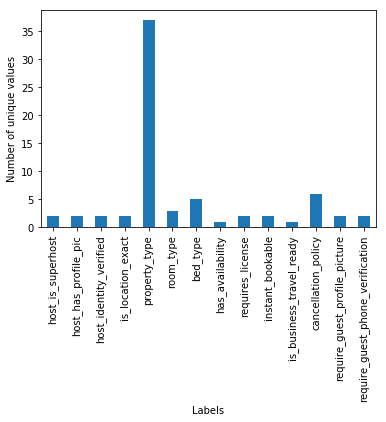

In [31]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_values = df_dl_clean_df[need_dummy_encoding].apply(pd.Series.nunique, axis='rows')
print(num_unique_values)

# Plot number of unique values for each label
num_unique_values.plot(kind='bar')
# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

It appears there are far too many property types in this data. Let's check why that is. Looking at the below numbers, we can see that NYC has many peculiar propties, for instance, *Treehouse*, *boat*, *Earth house* etc. To stay focused, we will restrict our analysis to *Apartment*, *House*, *Townhouse* and *Condominium*.  

In [32]:
df_dl_clean_df.property_type.value_counts()

Apartment                 38605
House                      3846
Townhouse                  1659
Condominium                1495
Loft                       1412
Serviced apartment          505
Guest suite                 363
Hotel                       227
Boutique hotel              190
Other                       118
Bed and breakfast            88
Resort                       72
Hostel                       62
Guesthouse                   56
Bungalow                     38
Villa                        28
Tiny house                   19
Aparthotel                   17
Boat                         13
Camper/RV                    10
Cottage                       7
Tent                          6
Earth house                   4
Cabin                         3
Houseboat                     3
Casa particular (Cuba)        2
Yurt                          2
Farm stay                     2
Cave                          2
Barn                          2
Bus                           2
Lighthou

### Subset the data to include few property types

In [174]:
df_airbnb = df_dl_clean_df[df_dl_clean_df.property_type.isin(['Apartment', 'House', 'Townhouse', 'Condominium'])]

In [175]:
df_airbnb.head()

,id,name,summary,description,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2595,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,2,$0.00,1,1125,1.0,1125.0,t,13,17,31,288,46,12,f,f,f,strict_14_with_grace_period,t,t,2,1,0,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,f,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Harlem,Manhattan,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,2,$20.00,3,7,3.0,7.0,t,30,60,90,365,0,0,f,f,f,strict_14_with_grace_period,t,t,1,0,1,0
3,5022,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,NaN,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,1,$20.00,10,120,10.0,120.0,t,0,0,0,0,9,2,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,2,$100.00,3,21,3.0,21.0,t,24,33,63,127,75,10,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
5,5121,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,f,Apartment,Private room,2,NaN,1.0,1.0,Futon,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",$60.00,1,$30.00,45,730,45.0,730.0,t,0,0,0,0,49,0,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0


In [35]:
missing_df = missing_statistics(df_airbnb)
missing_df

,num_missing,pct_missing
summary,1938,4.0
description,797,2.0
bathrooms,55,0.0
beds,38,0.0
bedrooms,25,0.0
host_has_profile_pic,17,0.0
host_identity_verified,17,0.0
host_total_listings_count,17,0.0
host_listings_count,17,0.0
host_is_superhost,17,0.0


The missing values for columns starting with host seem to have a pattern. Since all these columns have 17 missing values, it could be possible that the data is missing purpose.

In [36]:
cols_missing_values = list(missing_df[missing_df.num_missing > 0].index)

In [37]:
df_airbnb_missing_values = df_airbnb[cols_missing_values]
df_airbnb_missing_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45605 entries, 0 to 48863
Data columns (total 12 columns):
summary                      43667 non-null object
description                  44808 non-null object
bathrooms                    45550 non-null float64
beds                         45567 non-null float64
bedrooms                     45580 non-null float64
host_has_profile_pic         45588 non-null object
host_identity_verified       45588 non-null object
host_total_listings_count    45588 non-null float64
host_listings_count          45588 non-null float64
host_is_superhost            45588 non-null object
name                         45589 non-null object
cancellation_policy          45604 non-null object
dtypes: float64(5), object(7)
memory usage: 4.5+ MB


In [39]:
host_cols = list(df_airbnb_missing_values.columns[df_airbnb_missing_values.columns.str.contains('host')])

In [41]:
df_airbnb_missing_values[host_cols][df_airbnb_missing_values.host_identity_verified.isnull()]

,host_has_profile_pic,host_identity_verified,host_total_listings_count,host_listings_count,host_is_superhost
2451,NaN,NaN,NaN,NaN,NaN
2715,NaN,NaN,NaN,NaN,NaN
5962,NaN,NaN,NaN,NaN,NaN
6198,NaN,NaN,NaN,NaN,NaN
6454,NaN,NaN,NaN,NaN,NaN
8108,NaN,NaN,NaN,NaN,NaN
8974,NaN,NaN,NaN,NaN,NaN
9642,NaN,NaN,NaN,NaN,NaN
10692,NaN,NaN,NaN,NaN,NaN
14184,NaN,NaN,NaN,NaN,NaN


### Handling Missing Values
- For columns containing text, we will be replacing them with an empty string.
- For categorical columns, we will be replacing missing values with the mode.
- For continuous columns, we will be replacing the missing values with the median.

**TEXT COLUMNS**:

In [302]:
df_airbnb_clean = df_airbnb.copy(deep=True)
df_airbnb_clean.shape

(45605, 47)

In [303]:
# to avoid setcopywithwarning use .copy() - this will tell pandas use a copy and not a view.
df_airbnb_clean.loc[df_airbnb_clean.summary.isna().copy(), 'summary'] = ''
df_airbnb_clean.loc[df_airbnb_clean.description.isna().copy(), 'description'] = ''
df_airbnb_clean.loc[df_airbnb_clean.name.isna().copy(), 'name'] = ''

**CATEGORICAL COLUMNS**:

In [304]:
from sklearn.impute import SimpleImputer
category_missing_cols = ['host_has_profile_pic', 'host_identity_verified', 
                         'host_is_superhost', 'cancellation_policy']

float_missing_cols = ['bathrooms', 'beds', 'bedrooms', 
                      'host_total_listings_count', 
                      'host_listings_count']

In [278]:
index,_ = np.where(df_airbnb_clean[float_missing_cols].isna() == True)

In [279]:
df_airbnb_clean.iloc[index, :]

,id,name,summary,description,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
3,5022,Entire Apt: Spacious Studio/Loft by central park,,Loft apartment with high ceiling and wood floo...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,NaN,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,1,$20.00,10,120,10.0,120.0,t,0,0,0,0,9,2,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
5,5121,BlissArtsSpace!,,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,f,Apartment,Private room,2,NaN,1.0,1.0,Futon,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",$60.00,1,$30.00,45,730,45.0,730.0,t,0,0,0,0,49,0,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0
14,6848,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,Comfortable studio apartment with super comfor...,f,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,Williamsburg,Brooklyn,40.70837,-73.95352,t,Apartment,Entire home/apt,3,1.0,NaN,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free stre...",$140.00,2,$20.00,2,90,2.0,90.0,t,5,7,12,23,154,54,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
25,9357,Midtown Pied-a-terre,"HELLO. PLEASE DO NOT HIT ""REQUEST TO BOOK"". H...","HELLO. PLEASE DO NOT HIT ""REQUEST TO BOOK"". H...",f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Hell's Kitchen,Manhattan,40.76715,-73.98533,t,Apartment,Entire home/apt,2,1.0,NaN,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets allo...",$150.00,2,$0.00,10,1125,10.0,1125.0,t,0,0,0,104,58,0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
89,20724,Sunny room+Pvte office in huge loft,FOR RENT is 400sqf brand new renovated room co...,FOR RENT is 400sqf brand new renovated room co...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Bushwick,Brooklyn,40.70032,-73.93830,t,Apartment,Private room,1,NaN,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Smoking allowed"",""Pets...",$65.00,1,$15.00,4,100,4.0,100.0,t,11,15,24,299,24,5,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0
101,23501,Monkey Retreat Manhattan,,This listing is NO LONGER active. ___________...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Washington Heights,Manhattan,40.83927,-73.94281,t,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Breakfast,""Buzzer/wi...",$65.00,1,$30.00,2,20,2.0,20.0,t,6,36,66,341,68,0,f,f,f,strict_14_with_grace_period,t,t,1,0,1,0
121,27883,East Village Sanctuary,"Sorry, this listing is no longer available.","Sorry, this listing is no longer available.",f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,East Village,Manhattan,40.72245,-73.98527,t,Apartment,Entire home/apt,3,1.0,NaN,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,2,$35.00,4,365,4.0,365.0,t,0,0,0,0,25,0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
148,36121,Lg Rm in Historic Prospect Heights,,Sublet starting 15 July 2017 Available Room: 1...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Prospect Heights

In [281]:
indexes = list(index)

In [306]:
def replace_missing_values(cols, df):
    for col in cols:
        if df[col].dtype == 'O':
            print(col)
            mode_imputer = SimpleImputer(strategy='most_frequent')
            df.loc[:, col] = mode_imputer.fit_transform(df[[col]])
        elif df[col].dtype == 'float64' or df[col].dtype == 'int64':
            print(col)
            median_imputer = SimpleImputer(strategy='median')
            df.loc[:, col] = median_imputer.fit_transform(df[[col]])
        else:
            raise ValueError("Invalid column type")
    
    return df

In [307]:
df_airbnb_clean = replace_missing_values(float_missing_cols, df_airbnb_clean)
df_airbnb_clean = replace_missing_values(category_missing_cols, df_airbnb_clean)

bathrooms
beds
bedrooms
host_total_listings_count
host_listings_count
host_has_profile_pic
host_identity_verified
host_is_superhost
cancellation_policy


In [284]:
df_airbnb_clean.iloc[indexes, :]

,id,name,summary,description,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
3,5022,Entire Apt: Spacious Studio/Loft by central park,,Loft apartment with high ceiling and wood floo...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,1,$20.00,10,120,10.0,120.0,t,0,0,0,0,9,2,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
5,5121,BlissArtsSpace!,,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,f,Apartment,Private room,2,1.0,1.0,1.0,Futon,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",$60.00,1,$30.00,45,730,45.0,730.0,t,0,0,0,0,49,0,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0
14,6848,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,Comfortable studio apartment with super comfor...,f,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,Williamsburg,Brooklyn,40.70837,-73.95352,t,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free stre...",$140.00,2,$20.00,2,90,2.0,90.0,t,5,7,12,23,154,54,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
25,9357,Midtown Pied-a-terre,"HELLO. PLEASE DO NOT HIT ""REQUEST TO BOOK"". H...","HELLO. PLEASE DO NOT HIT ""REQUEST TO BOOK"". H...",f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,Hell's Kitchen,Manhattan,40.76715,-73.98533,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets allo...",$150.00,2,$0.00,10,1125,10.0,1125.0,t,0,0,0,104,58,0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
89,20724,Sunny room+Pvte office in huge loft,FOR RENT is 400sqf brand new renovated room co...,FOR RENT is 400sqf brand new renovated room co...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Bushwick,Brooklyn,40.70032,-73.93830,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Smoking allowed"",""Pets...",$65.00,1,$15.00,4,100,4.0,100.0,t,11,15,24,299,24,5,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0
101,23501,Monkey Retreat Manhattan,,This listing is NO LONGER active. ___________...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Washington Heights,Manhattan,40.83927,-73.94281,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,Breakfast,""Buzzer/wi...",$65.00,1,$30.00,2,20,2.0,20.0,t,6,36,66,341,68,0,f,f,f,strict_14_with_grace_period,t,t,1,0,1,0
121,27883,East Village Sanctuary,"Sorry, this listing is no longer available.","Sorry, this listing is no longer available.",f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,East Village,Manhattan,40.72245,-73.98527,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$100.00,2,$35.00,4,365,4.0,365.0,t,0,0,0,0,25,0,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
148,36121,Lg Rm in Historic Prospect Heights,,Sublet starting 15 July 2017 Available Room: 1...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Prospect Heights

In [308]:
df_airbnb_clean.isna().sum()

id                                              0
name                                            0
summary                                         0
description                                     0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
neighbourhood_group_cleansed                    0
latitude                                        0
longitude                                       0
is_location_exact                               0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0


## Clean the columns
Some columns like `price` are represented as objects since we have a dollar sign. Before we proceed further with our analysis, we need to clean these columns. 

Secondly, we need to make sure that there are no outliers. May not be required for unsupervised classification algorithms, but we will explore.

In [313]:
df_airbnb_clean.head()

,id,name,summary,description,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2595,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,Midtown,Manhattan,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",$225.00,2,$0.00,1,1125,1.0,1125.0,t,13,17,31,288,46,12,f,f,f,strict_14_with_grace_period,t,t,2,1,0,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,f,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,Harlem,Manhattan,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",$150.00,2,$20.00,3,7,3.0,7.0,t,30,60,90,365,0,0,f,f,f,strict_14_with_grace_period,t,t,1,0,1,0
3,5022,Entire Apt: Spacious Studio/Loft by central park,,Loft apartment with high ceiling and wood floo...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Harlem,Manhattan,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",$80.00,1,$20.00,10,120,10.0,120.0,t,0,0,0,0,9,2,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,Murray Hill,Manhattan,40.74767,-73.97500,f,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",$200.00,2,$100.00,3,21,3.0,21.0,t,24,33,63,127,75,10,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0
5,5121,BlissArtsSpace!,,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,f,Apartment,Private room,2,1.0,1.0,1.0,Futon,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",$60.00,1,$30.00,45,730,45.0,730.0,t,0,0,0,0,49,0,f,f,f,strict_14_with_grace_period,f,f,1,0,1,0


#### Cleaning price and extra_people

In [345]:
import re
df_airbnb_clean['price'] = df_airbnb_clean.price.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')
df_airbnb_clean['extra_people'] = df_airbnb_clean.extra_people.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')

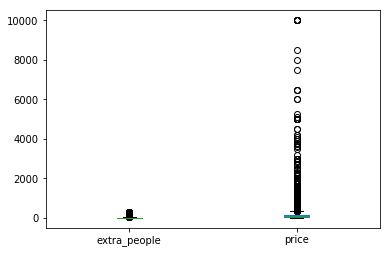

In [349]:
df_airbnb_clean[['extra_people', 'price']].plot(kind='box')

Price has quite many outliers, we will deal with outliers in the next stage.

### Clean all data types

In [350]:
df_airbnb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45605 entries, 0 to 48863
Data columns (total 47 columns):
id                                              45605 non-null int64
name                                            45605 non-null object
summary                                         45605 non-null object
description                                     45605 non-null object
host_is_superhost                               45605 non-null object
host_listings_count                             45605 non-null float64
host_total_listings_count                       45605 non-null float64
host_verifications                              45605 non-null object
host_has_profile_pic                            45605 non-null object
host_identity_verified                          45605 non-null object
neighbourhood_cleansed                          45605 non-null object
neighbourhood_group_cleansed                    45605 non-null object
latitude                                        45

In [359]:
categorical_types = ['host_is_superhost',
                     'host_has_profile_pic',
                     'host_identity_verified',
                     'is_location_exact',
                     'property_type',
                     'room_type',
                     'bed_type',
                     'has_availability',
                     'requires_license',
                     'instant_bookable',
                     'is_business_travel_ready',
                     'cancellation_policy',
                     'require_guest_profile_picture',
                     'require_guest_phone_verification']

In [360]:
df_airbnb_clean[categorical_types].dtypes

host_is_superhost                   object
host_has_profile_pic                object
host_identity_verified              object
is_location_exact                   object
property_type                       object
room_type                           object
bed_type                            object
has_availability                    object
requires_license                    object
instant_bookable                    object
is_business_travel_ready            object
cancellation_policy                 object
require_guest_profile_picture       object
require_guest_phone_verification    object
dtype: object

In [371]:
df_airbnb_clean[categorical_types] = df_airbnb_clean[categorical_types].apply(lambda x: x.astype('category'), 
                                                                                axis='rows')

In [372]:
df_airbnb_clean[categorical_types].dtypes

host_is_superhost                   category
host_has_profile_pic                category
host_identity_verified              category
is_location_exact                   category
property_type                       category
room_type                           category
bed_type                            category
has_availability                    category
requires_license                    category
instant_bookable                    category
is_business_travel_ready            category
cancellation_policy                 category
require_guest_profile_picture       category
require_guest_phone_verification    category
dtype: object

In [374]:
df_airbnb_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45605 entries, 0 to 48863
Data columns (total 47 columns):
id                                              45605 non-null int64
name                                            45605 non-null object
summary                                         45605 non-null object
description                                     45605 non-null object
host_is_superhost                               45605 non-null category
host_listings_count                             45605 non-null float64
host_total_listings_count                       45605 non-null float64
host_verifications                              45605 non-null object
host_has_profile_pic                            45605 non-null category
host_identity_verified                          45605 non-null category
neighbourhood_cleansed                          45605 non-null object
neighbourhood_group_cleansed                    45605 non-null object
latitude                                    

In [381]:
availabity = list(df_airbnb_clean.columns[df_airbnb_clean.columns.str.contains('avail')])

In [382]:
df_airbnb_clean[availabity].head()

,has_availability,availability_30,availability_60,availability_90,availability_365
0,t,13,17,31,288
1,t,30,60,90,365
3,t,0,0,0,0
4,t,24,33,63,127
5,t,0,0,0,0


### One-hot encode the categorical variables

In [383]:
category_one_hot_encoding = pd.get_dummies(df_airbnb_clean[categorical_types])

In [384]:
category_one_hot_encoding.head()

,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,is_location_exact_f,is_location_exact_t,property_type_Apartment,property_type_Condominium,property_type_House,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,has_availability_t,requires_license_f,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
3,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
4,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
5,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0


In [385]:
category_one_hot_encoding.shape

(45605, 35)

In [386]:
df_airbnb_clean.shape

(45605, 47)

We need to merge these two and drop the categorical variables

In [395]:
df_airbnb_clean = pd.concat([df_airbnb_clean, category_one_hot_encoding], 
                            axis='columns').drop(categorical_types, 
                                                 axis='columns')
df_airbnb_clean.shape

(45605, 68)

In [396]:
df_airbnb_clean.head()

,id,name,summary,description,host_listings_count,host_total_listings_count,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,is_location_exact_f,is_location_exact_t,property_type_Apartment,property_type_Condominium,property_type_House,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,has_availability_t,requires_license_f,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,2595,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","Find your romantic getaway to this beautiful, ...",5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",Midtown,Manhattan,40.75362,-73.98377,2,1.0,0.0,1.0,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",225.0,2,0.0,1,1125,1.0,1125.0,13,17,31,288,46,12,2,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",Harlem,Manhattan,40.80902,-73.94190,2,1.0,1.0,1.0,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",150.0,2,20.0,3,7,3.0,7.0,30,60,90,365,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
3,5022,Entire Apt: Spacious Studio/Loft by central park,,Loft apartment with high ceiling and wood floo...,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",East Harlem,Manhattan,40.79851,-73.94399,1,1.0,1.0,1.0,"{Internet,Wifi,""Air conditioning"",Kitchen,Elev...",80.0,1,20.0,10,120,10.0,120.0,0,0,0,0,9,2,1,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
4,5099,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment is true New York ...,My large 1 bedroom apartment is true New York ...,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",Murray Hill,Manhattan,40.74767,-73.97500,2,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...",200.0,2,100.0,3,21,3.0,21.0,24,33,63,127,75,10,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1
5,5121,BlissArtsSpace!,,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,2,1.0,1.0,1.0,"{Wifi,""Air conditioning"",Kitchen,""Pets live on...",60.0,1,30.0,45,730,45.0,730.0,0,0,0,0,49,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,0


In [397]:
df_airbnb_clean.to_csv('airbnb_clean.csv', index=False)

## Analyze amenities

In [30]:
df_dl_clean_df['amenities'] =  df_dl_clean_df['amenities'].apply(lambda x: x[1:-1])

In [31]:
amenities = df_dl_clean_df['amenities']

In [32]:
amenities_idx ={}
idx = 0
corpus = []
for i in range(len(amenities)):
    items = amenities[i]
    items_lower = items.lower()
    tokens = items_lower.split(',')
    corpus.append(tokens)
    for token in tokens:
        if token not in amenities_idx:
            amenities_idx[token] = idx
            idx += 1

In [33]:
len(amenities_idx)

131

In [34]:
len(corpus)

48864

In [35]:
# Get the number of items and tokens 
M = len(amenities)
N = len(amenities_idx)

# Initialize a matrix of zeros
A = np.zeros((M, N))

In [36]:
# Define the amenity_encoder function
def amenity_encoder(tokens):
    x = np.zeros(N)
    for token in tokens:
        # Get the index for each amenity
        idx = amenities_idx[token]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x

In [37]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = amenity_encoder(tokens)
    i = i + 1

In [38]:
A.shape

(48864, 131)

In [40]:
from sklearn.manifold import TSNE

In [ ]:
# Dimension reduction with t-SNE
model = TSNE(n_components=2, learning_rate=200, random_state=42)
tsne_features = model.fit_transform(A)

In [42]:
tsne_df = pd.DataFrame({'TSNE1': tsne_features[:,0], 
              'TSNE2': tsne_features[:,1]
             })

In [43]:
subset_cols = ['id', 'price', 'amenities', 
               'neighbourhood_cleansed', 
               'neighbourhood_group_cleansed',
               'latitude', 'longitude'
              ]

In [44]:
df_dl_clean_df = df_dl_clean_df[subset_cols]

In [45]:
df_dl_clean_df = pd.concat([df_dl_clean_df, tsne_df], axis='columns')

In [46]:
df_dl_clean_df.head()

,id,price,amenities,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,TSNE1,TSNE2
0,2595,$225.00,"TV,Wifi,""Air conditioning"",Kitchen,""Paid parki...",Midtown,Manhattan,40.75362,-73.98377,42.803360,-10.623417
1,3647,$150.00,"""Cable TV"",Internet,Wifi,""Air conditioning"",Ki...",Harlem,Manhattan,40.80902,-73.94190,-34.314285,13.559643
2,3831,$89.00,"TV,""Cable TV"",Internet,Wifi,""Air conditioning""...",Clinton Hill,Brooklyn,40.68514,-73.95976,3.406300,-22.669363
3,5022,$80.00,"Internet,Wifi,""Air conditioning"",Kitchen,Eleva...",East Harlem,Manhattan,40.79851,-73.94399,-11.913917,-8.425117
4,5099,$200.00,"TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/wi...",Murray Hill,Manhattan,40.74767,-73.97500,-12.099396,-1.838848


In [47]:
df_dl_clean_df.to_csv('tsne-results.csv', index=False)

### Visualizing t-sne results

In [88]:
from bokeh.io import show, output_notebook, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()


Loading BokehJS ...

In [97]:
# Make a source and a scatter plot  
source = ColumnDataSource(df_dl_clean_df[:100])

In [98]:
plot = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot.circle(x = 'TSNE1', 
    y = 'TSNE2', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

GlyphRenderer(id='1408', ...)

In [99]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('id', '@id'),
                              ('price', '$@price')
                             ])
plot.add_tools(hover)

In [100]:
output_file('amenities.html')
show(plot)

## To do

In [ ]:
# more columns that can be removed
# experiences_offered, contains all none's so no use.
more_cols = ['experiences_offered']